In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from medmnist import BloodMNIST

2025-04-28 12:22:35.058861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745857355.078613    8115 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745857355.084509    8115 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745857355.099783    8115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745857355.099814    8115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745857355.099816    8115 computation_placer.cc:177] computation placer alr

In [2]:
import random
import os

def set_seed(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)  
    random.seed(seed)                         
    np.random.seed(seed)                      
    tf.random.set_seed(seed)                  

set_seed(123)

## Resolution: 128x128

### ResNet50_128

In [3]:
# 1. Load dataset
data_128 = np.load("bloodmnist_128.npz")

# 2. Extract images and labels
train_images_128 = data_128["train_images"]
train_labels_128 = data_128["train_labels"].flatten()

val_images_128 = data_128["val_images"]
val_labels_128 = data_128["val_labels"].flatten()

test_images_128 = data_128["test_images"]
test_labels_128 = data_128["test_labels"].flatten()

In [4]:
# 3. One-hot encode labels
train_labels_cat_128 = to_categorical(train_labels_128, num_classes=8)
val_labels_cat_128 = to_categorical(val_labels_128, num_classes=8)
test_labels_cat_128 = to_categorical(test_labels_128, num_classes=8)

In [5]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator_128 = train_datagen.flow(
    train_images_128, 
    train_labels_cat_128,   
    batch_size=batch_size
)
val_generator_128 = test_datagen.flow(
    val_images_128,
    val_labels_cat_128,
    batch_size=batch_size
)
test_generator_128 = test_datagen.flow(
    test_images_128,
    test_labels_cat_128,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
# 5. Set up ResNet50 
base_50_128 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

x = base_50_128.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_128 = Model(inputs=base_50_128.input, outputs=outputs)

2025-04-28 12:23:56.480493: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
# 6. Compile model
model_50_128.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

In [8]:
# 7. Train model
history_50_128 = model_50_128.fit(
    train_generator_128,
    epochs=10,
    validation_data=val_generator_128
)

/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1147s 3s/step - accuracy: 0.8515 - auc: 0.9707 - loss: 0.4424 - val_accuracy: 0.0888 - val_auc: 0.4756 - val_loss: 7.7443
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1113s 3s/step - accuracy: 0.9686 - auc: 0.9976 - loss: 0.0934 - val_accuracy: 0.1758 - val_auc: 0.6813 - val_loss: 3.2664
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1118s 3s/step - accuracy: 0.9806 - auc: 0.9984 - loss: 0.0611 - val_accuracy: 0.9597 - val_auc: 0.9987 - val_loss: 0.1148
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1111s 3s/step - accuracy: 0.9865 - auc: 0.9996 - loss: 0.0409 - val_accuracy: 0.9766 - val_auc: 0.9996 - val_loss: 0.0693
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1104s 3s/step - accuracy: 0.9865 - auc: 0.9995 - loss: 0.0435 - val_accuracy: 0.9737 - val_auc: 0.9985 - val_loss: 0.0931
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1103s 3s/step - accuracy: 0.9870 - auc: 0.9997 - loss: 0.0363 - val_accuracy: 0.9790 - val_auc: 0.9995 - val_loss: 0.0660
Epoch 7/10
374/374 ━━━━━━━━━

In [9]:
model_50_128.save('model_output/ResNet50_128.h5')
model_50_128.save('model_output/ResNet50_128.keras')

# to load:
# from keras.models import load_model
# model_50_128 = load_model('model_output/ResNet50_128.h5')
# from tensorflow.keras.models import load_model
# model_50_128 = load_model('model_output/ResNet50_128.h5')

In [10]:
# 8. Evaluate model
test_loss_50_128, test_acc_50_128, test_auc_50_128 = model_50_128.evaluate(test_generator_128)
print(f"ResNet50 test accuracy for 128 pixels: {test_acc_50_128:.4f}")
print(f"ResNet50 test AUC for 128 pixels:      {test_auc_50_128:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 47s 435ms/step - accuracy: 0.9875 - auc: 0.9990 - loss: 0.0408
ResNet50 test accuracy for 128 pixels: 0.9860
ResNet50 test AUC for 128 pixels:      0.9989


In [13]:
# 9. Precision, recall, f1-score
y_prob_50_128 = model_50_128.predict(test_generator_128)
y_pred_50_128 = np.argmax(y_prob_50_128, axis=1)
y_true_128 = test_labels_128

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_128, y_pred_50_128, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 47s 435ms/step
                      precision    recall  f1-score   support

          neutrophil       0.99      0.99      0.99       244
          eosinophil       1.00      1.00      1.00       624
            basophil       1.00      0.98      0.99       311
          lymphocyte       0.96      0.97      0.97       579
            monocyte       1.00      0.99      0.99       243
immature granulocyte       0.99      0.98      0.99       284
        erythroblast       0.97      0.98      0.98       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.99      3421
           macro avg       0.99      0.99      0.99      3421
        weighted avg       0.99      0.99      0.99      3421



In [14]:
# 10. Performance per class
cm_50_128 = confusion_matrix(y_true_128, y_pred_50_128)
per_class_acc_50_128 = cm_50_128.diagonal() / cm_50_128.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_128):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9918
eosinophil           accuracy: 1.0000
basophil             accuracy: 0.9839
lymphocyte           accuracy: 0.9672
monocyte             accuracy: 0.9877
immature granulocyte accuracy: 0.9824
erythroblast         accuracy: 0.9805
platelet             accuracy: 0.9979


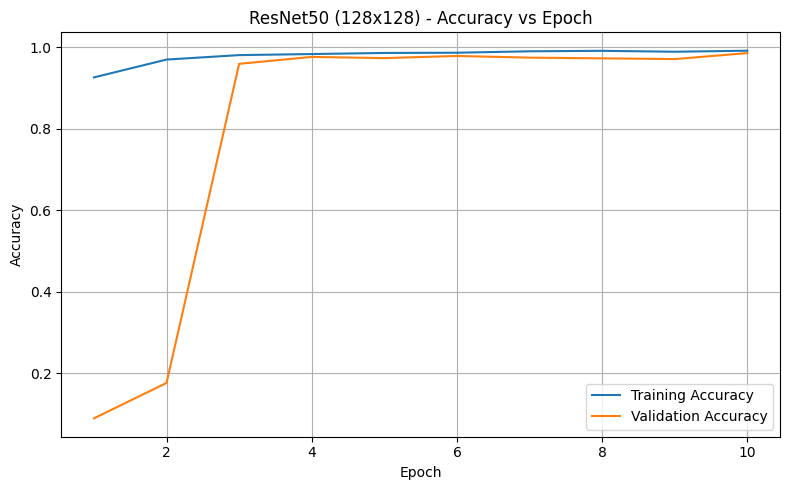

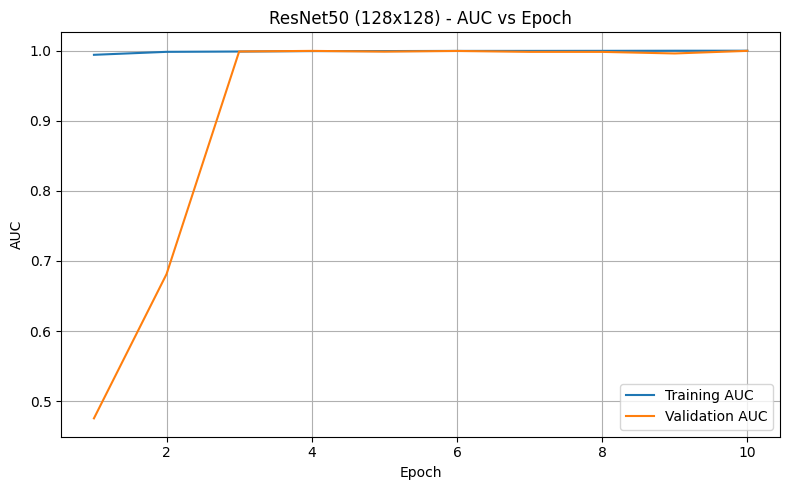

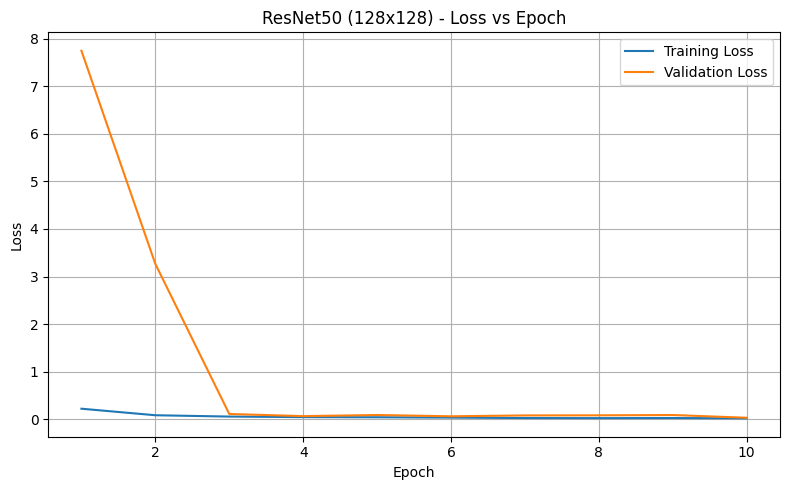

In [15]:
# 11. Plot
epochs = range(1, len(history_50_128.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_128.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (128x128) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_128.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_128.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (128x128) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_128.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_128.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (128x128) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_128.png")
plt.show()

### ResNet101_128

In [16]:
# 5. Set up ResNet101
base_101_128 = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

x = base_101_128.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_101_128 = Model(inputs=base_101_128.input, outputs=outputs)

In [17]:
# 6. Compile model
model_101_128.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
)

In [18]:
# 7. Train model
history_101_128 = model_101_128.fit(
    train_generator_128,
    epochs=10,
    validation_data=val_generator_128
)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1902s 5s/step - accuracy: 0.8586 - auc: 0.9722 - loss: 0.4213 - val_accuracy: 0.1822 - val_auc: 0.4998 - val_loss: 27.4401
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1851s 5s/step - accuracy: 0.9777 - auc: 0.9989 - loss: 0.0692 - val_accuracy: 0.3785 - val_auc: 0.7699 - val_loss: 3.5275
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1848s 5s/step - accuracy: 0.9815 - auc: 0.9989 - loss: 0.0594 - val_accuracy: 0.9211 - val_auc: 0.9932 - val_loss: 0.2510
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1844s 5s/step - accuracy: 0.9830 - auc: 0.9989 - loss: 0.0513 - val_accuracy: 0.9393 - val_auc: 0.9939 - val_loss: 0.2214
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1856s 5s/step - accuracy: 0.9890 - auc: 0.9990 - loss: 0.0358 - val_accuracy: 0.9848 - val_auc: 0.9993 - val_loss: 0.0507
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1850s 5s/step - accuracy: 0.9868 - auc: 0.9991 - loss: 0.0389 - val_accuracy: 0.9725 - val_auc: 0.9983 - val_loss: 0.0897
Epoch 7/10
374/374 ━━━━━━━━

In [21]:
model_101_128.save('model_output/ResNet101_128.h5')
model_101_128.save('model_output/ResNet101_128.keras')

# to load:
# from keras.models import load_model
# model_101_64 = load_model('model_101_64.keras')
# from tensorflow.keras.models import load_model
# model_101_64 = load_model('model_101_64.h5', compile=False)

In [20]:
# 8. Evaluate model
test_loss_101_128, test_acc_101_128, test_auc_101_128 = model_101_128.evaluate(test_generator_128)
print(f"ResNet101 test accuracy for 128 pixels: {test_acc_101_128:.4f}")
print(f"ResNet101 test AUC for 128 pixels:      {test_auc_101_128:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 771ms/step - accuracy: 0.9732 - auc: 0.9982 - loss: 0.0799
ResNet101 test accuracy for 128 pixels: 0.9728
ResNet101 test AUC for 128 pixels:      0.9975


In [22]:
# 9. Classification report
y_prob_101_128 = model_101_128.predict(test_generator_128)
y_pred_101_128 = np.argmax(y_prob_101_128, axis=1)
y_true_128 = test_labels_128

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}
class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_128, y_pred_101_128, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 88s 794ms/step
                      precision    recall  f1-score   support

          neutrophil       0.86      1.00      0.92       244
          eosinophil       1.00      1.00      1.00       624
            basophil       1.00      0.97      0.99       311
          lymphocyte       0.97      0.89      0.93       579
            monocyte       0.98      1.00      0.99       243
immature granulocyte       0.99      0.96      0.98       284
        erythroblast       0.96      0.98      0.97       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.97      3421
           macro avg       0.97      0.98      0.97      3421
        weighted avg       0.97      0.97      0.97      3421



In [23]:
# 10. Per-class accuracy
cm_101_128 = confusion_matrix(y_true_128, y_pred_101_128)
per_class_acc_101_128 = cm_101_128.diagonal() / cm_101_128.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_128):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 1.0000
eosinophil           accuracy: 1.0000
basophil             accuracy: 0.9743
lymphocyte           accuracy: 0.8912
monocyte             accuracy: 0.9959
immature granulocyte accuracy: 0.9648
erythroblast         accuracy: 0.9850
platelet             accuracy: 0.9979


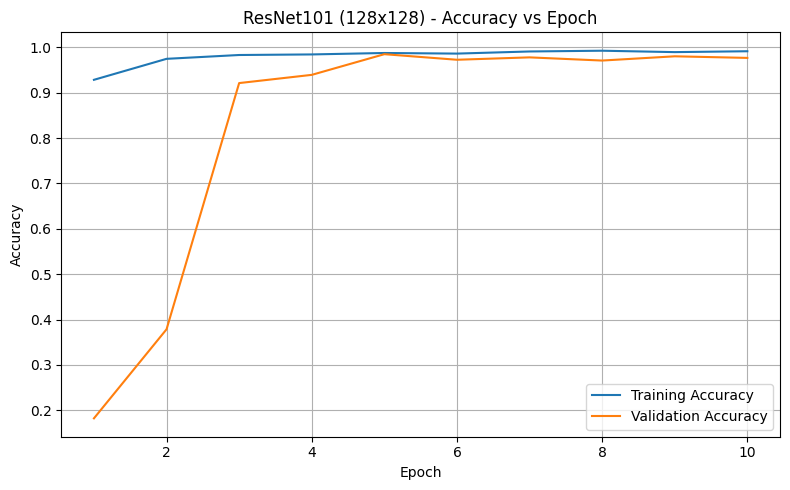

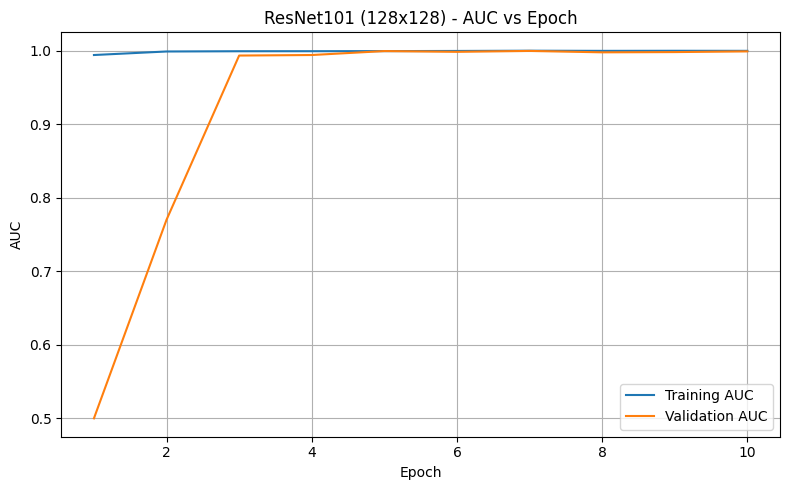

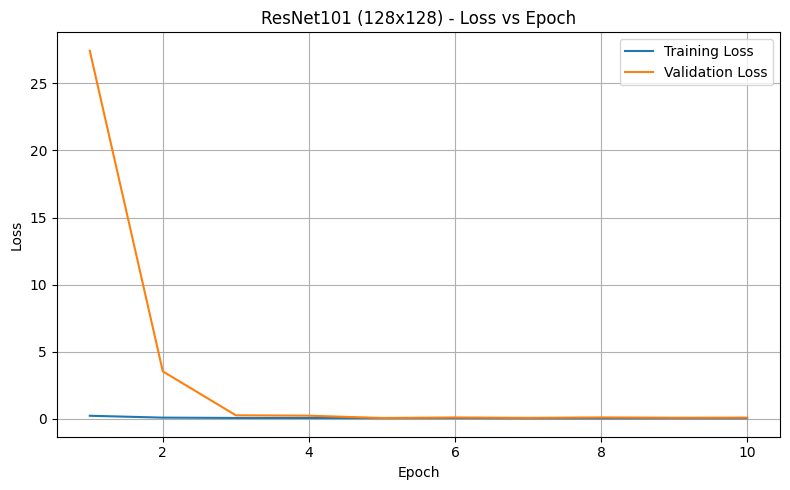

In [24]:
# 11. Plot
epochs = range(1, len(history_101_128.history['loss']) + 1)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_128.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_101_128.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 (128x128) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet101_128.png")
plt.show()

# AUC plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_128.history['auc'], label='Training AUC')
plt.plot(epochs, history_101_128.history['val_auc'], label='Validation AUC')
plt.title('ResNet101 (128x128) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet101_128.png")
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_128.history['loss'], label='Training Loss')
plt.plot(epochs, history_101_128.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 (128x128) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet101_128.png")
plt.show()